Data Visualization Notebook with FBref-DW Merged Data:

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as so
import numpy as np
# Graph output styling from matplotlib:
plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')

In [30]:
# Global variables:
repo_dir = os.getcwd()  # Directory of the notebook
source_data_dir = os.path.join(repo_dir, 'fbref-dw-merges')
league_ids = ['ENG-Premier League', 'ESP-La Liga', 'FRA-Ligue 1', 'ITA-Serie A'] # For league-level iteration
league_names = ['Premier League', 'La Liga', 'Ligue 1', 'Serie A']
seasons = [1718, 1819, 1920, 2021, 2122, 2223]
vis_dir = 'C:\Users\cmart\OneDrive - Bentley University\Research\Player Valuation Model\VISUALIZATIONS\Pre-Analysis'

# Create a statistics dictionary for the DEF category:
df_stat_dict = {'MP': 'mean',         # total matches played
                  '90s_r': 'mean',     # number of 90s played
                  'Min': 'mean',       # number of minutes played
                  'Tkl': 'mean',       # total tackles
                  'TklW': 'mean',      # total tackles won
                  'Def 3rd': 'mean',   # total tackles in def. 3rd
                  'Mid 3rd': 'mean',   # total tackles in mid. 3rd
                  'Blocks.1' : 'mean', # total blocks
                  'Sh.3': 'mean',      # total shots blocked
                  'market_value_in_eur': 'mean',
                  'big_team' : 'mean'     # big 6 dummy
                  }

# Create a statistics dictionary for the MID category:
mf_stat_dict = {'MP': 'mean',          # total matches played
                  '90s_r': 'mean',      # number of 90s played
                  'Min': 'mean',        # number of minutes played
                  'Gls.1': 'mean',       # goals/90
                  'Ast.1': 'mean',      # assists/90
                  'G-PK.1': 'mean',     # npg per 90
                  'G+A-PK': 'mean',     # npg+a per 90
                  'npxG+xAG.1' : 'mean',
                  'SoT%': 'mean',
                  'Cmp%': 'mean',       # overall pass completion
                  'Cmp%.1': 'mean',     # mid-range pass completion
                  'SCA90': 'mean',
                  'GCA90': 'mean',
                  'Tkl%': 'mean',       # successful tackle rate
                  'PrgC.1': 'mean',     # total progressive carries
                  'market_value_in_eur': 'mean',
                  'big_team' : 'mean'     # big 6 dummy
                  }

# Create a statistics dictionary for the FW category:
fw_stat_dict = {'MP': 'mean',           # total matches played
                  '90s_r': 'mean',      # number of 90s played
                  'Min': 'mean',        # number of minutes played
                  'Gls.1': 'mean',      # goals/90
                  'Ast.1': 'mean',      # assists/90
                  'G-PK.1': 'mean',     # npg per 90
                  'G+A-PK': 'mean',     # npg+a per 90
                  'npxG+xAG.1' : 'mean', # per 90
                  'npxG.1': 'mean',     # per 90
                  'G/Sh': 'mean',       # overall pass completion
                  'G/SoT': 'mean',      # mid-range pass completion
                  'np:G-xG': 'mean',    # per 90
                  'A-xAG': 'mean',      # total A - xAG 
                  'Crs': 'mean',        # total crosses
                  'GCA90': 'mean',
                  'market_value_in_eur': 'mean',
                  'big_team' : 'mean'     # big 6 dummy
                  }

# Stat column lists by position:
df_stat_cols = [key for key in df_stat_dict]
mf_stat_cols = [key for key in mf_stat_dict]
fw_stat_cols = [key for key in fw_stat_dict]
# List of these lists:
stats_lists = [df_stat_cols, mf_stat_cols, fw_stat_cols]

# "Big Team" list:
big_teams = ['Arsenal', 'Manchester City', 'Manchester Utd', 'Tottenham', 'Chelsea', 'Liverpool', 'Real Madrid', 'Barcelona', 'Atlético Madrid', 'Paris S-G', 'Juventus', 'Milan', 'Inter']

# Seaborn pallette dictionaries
def_hue_colors = {0 : 'slategrey', 1 : 'goldenrod'}
mf_hue_colors = {0 : 'slategrey', 1 : 'lightseagreen'}
fw_hue_colors = {0 : 'slategrey', 1 : 'dodgerblue'}
# List of these dictionaries:
hue_dicts = [def_hue_colors, mf_hue_colors, fw_hue_colors]

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2785066086.py, line 7)

In [31]:
# Functions:
def filter_by_season_pos(df, pos, season):
    return (df[df['position'].str.contains(pos) & (df['season'] == season)])


# Import data from fbref-dw-merges directory:
def import_merged_data(league):
    return (pd.read_csv(os.path.join(source_data_dir, f"{league}_fbref_dw_merge.csv")))


# Add the log(market value) column to the data:
def add_log_mkt_val_col(df):
    df['log_mkt_val'] = np.log(df['market_value_in_eur'])
    return df


# Add the "Big Team" dummy variable to the data:
def add_big_team_col(df):
    df['big_team'] = df['team_x'].isin(big_teams).astype(int)
    return df


# Function that plots log(market value) against a given stat for each league in a specified season:
def position_stat_plots(df_list, position, season, stat, hue_dict):
    '''
    The 'df_list' argument of this function should be a list of four dataframes imported
    from the fbref-dw-merges directory in GitHub
    '''
    
    for df, league in zip(df_list, league_names):

        # Filter to position and season:
        filtered_df = filter_by_season_pos(df, position, season)

        # Add big team and log(value) columns:
        filtered_df = add_big_team_col(filtered_df)

        # Slice by necessary columns:
        if position == 'DEF':
            sliced_df = filtered_df[df_stat_cols]
        elif position == 'MF':
            sliced_df = filtered_df[mf_stat_cols]
        elif position == 'FW':
            sliced_df = filtered_df[fw_stat_cols]
        else:
            print("***INVALID POSITION ARGUMENT***")

        # Add the log(mkt value) column:
        sliced_df = add_log_mkt_val_col(sliced_df)

        # Add the per 90 statistics:
        # for col in sliced_df.iloc[:, 3:8]:  # needs to be fixed, doesn't apply to MF/FW dimensions
        #     sliced_df[f'{col}_per90'] = sliced_df[col] / sliced_df['90s_r']
        
        # Plot a single statistic for each league:
        so.scatterplot(data=sliced_df, x=stat, y='log_mkt_val', hue='big_team', palette=hue_dict)
        so.regplot(data=sliced_df, x=stat, y='log_mkt_val', line_kws={'color' : 'grey'}, scatter=False)
        plt.title(f'{league}')
        # so.despine(top=True, right=True)
        plt.show()

        # Save the plot as a file (optional):
        # plt.savefig(os.path.join(vis_dir, f'{league}_{stat}_plot.png'))

In [7]:
# Get the 5 leagues in:
league_dfs = [import_merged_data(league) for league in league_ids]

Generate the DF scatterplots for each league:

C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['big_team'] = df['team_x'].isin(big_teams).astype(int)
C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_mkt_val'] = np.log(df['market_value_in_eur'])


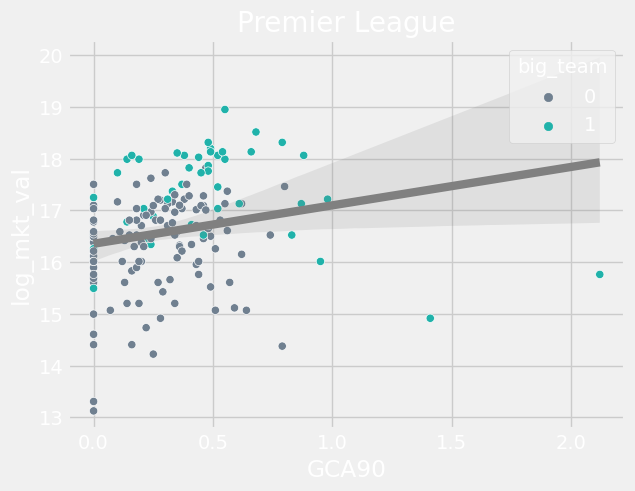

C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['big_team'] = df['team_x'].isin(big_teams).astype(int)
C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_mkt_val'] = np.log(df['market_value_in_eur'])


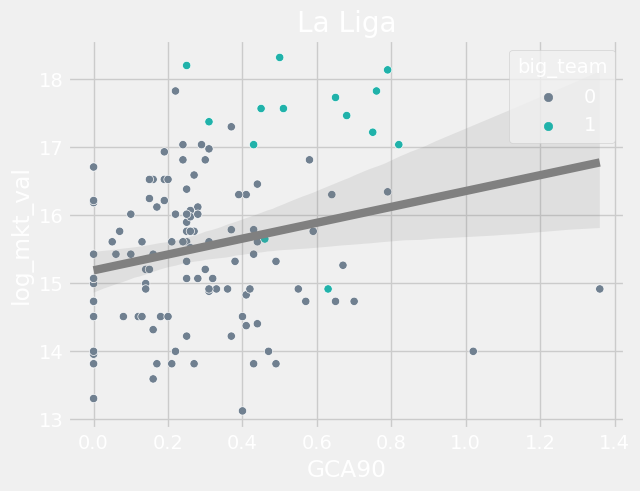

C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['big_team'] = df['team_x'].isin(big_teams).astype(int)
C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_mkt_val'] = np.log(df['market_value_in_eur'])


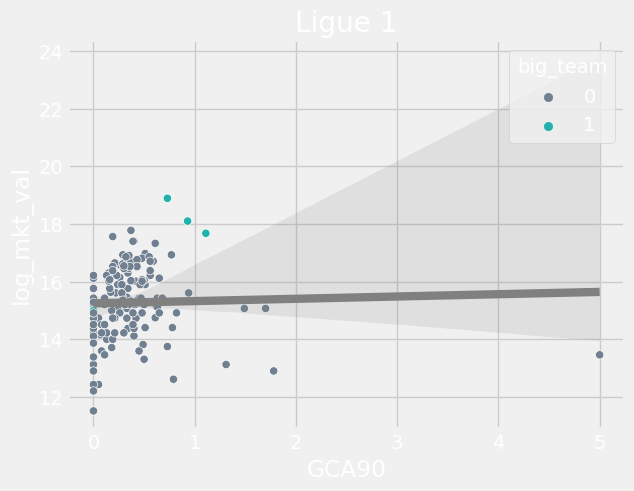

C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['big_team'] = df['team_x'].isin(big_teams).astype(int)
C:\Users\cmart\AppData\Local\Temp\ipykernel_15444\2955577076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_mkt_val'] = np.log(df['market_value_in_eur'])


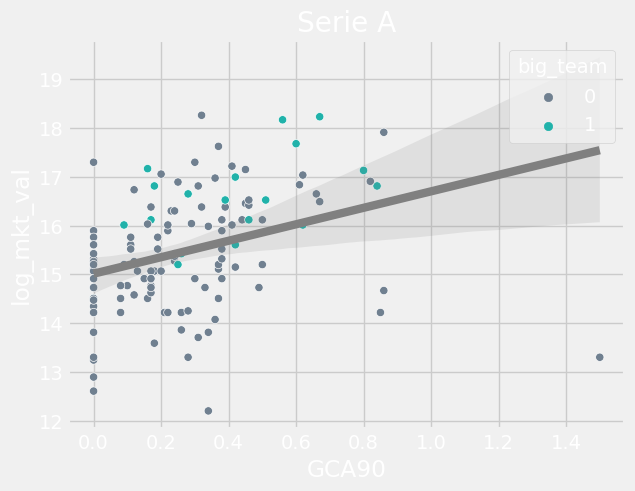

In [29]:
# Plot a statistic for each league for a position:
position_stat_plots(league_dfs, 'FW', 2223, 'GCA90', mf_hue_colors)

In [ ]:
big6_teams = ['Arsenal', 'Manchester City', 'Manchester Utd', 'Tottenham', 'Chelsea', 'Liverpool', 'Real Madrid', 'Barcelona', 'Atlético Madrid', 'Paris S-G', 'Juventus', 'Milan', 'Inter']

for df, league in zip(league_dfs, league_ids):

    # Filter to defenders only:
    df = df[df['position'] == 'DF']

    # Filter to 22/23 only:
    df = df[df['season'] == 2223]

    # Add the big six column:
    df['big_6'] = df['team_x'].isin(big6_teams).astype(int)

    # Slice to necessary defensive stat columns only:
    df = df[df_stat_cols]

    # Add the log(market value) column:
    df['log_mkt_val'] = np.log(df['market_value_in_eur'])

    # Add the per 90 statistics:
    for col in df.iloc[:, 3:8]:
        df[f'{col}_per90'] = df[col] / df['90s_r']

    # Plot a single statistic for each league:
    so.scatterplot(data=df, x='Blocks.1', y='log_mkt_val', hue='big_6', palette=def_hue_colors)
    so.regplot(data=df, x='Blocks.1', y='log_mkt_val', line_kws={'color' : 'grey'}, scatter=False)
    plt.title(f'{league}')
    plt.show()
    
    # Plot market value against each column of interest:
    # for col in df.columns:
    #     so.scatterplot(data=df, x=col, y="log_mkt_val")
    #     plt.title(f'{league} - {col}')
    #     plt.show()

In [ ]:
def position_stat_plots(position, season, stat, hue_dict):

    for df, league in zip(league_dfs, league_names):

        # Filter to position and season:
        filtered_df = filter_by_season_pos(df, position, season)

        # Add big team and log(value) columns:
        filtered_df = add_big_team_col(filtered_df)
        filtered_df = add_log_mkt_val_col(filtered_df)

        # Add the per 90 statistics:
        for col in filtered_df.iloc[:, 3:8]:
            filtered_df[f'{col}_per90'] = filtered_df[col] / filtered_df['90s_r']
        
        # Plot a single statistic for each league:
        so.scatterplot(data=df, x=stat, y='log_mkt_val', hue='big_team', palette=hue_dict)
        so.regplot(data=df, x=stat, y='log_mkt_val', line_kws={'color' : 'grey'}, scatter=False)
        plt.title(f'{league}')
        plt.show()

In [ ]:
# Import EPL data:
epl_player_data = pd.read_csv(os.path.join(source_data_dir, "ENG-Premier League_fbref_dw_merge.csv"))

# Add the "Big 6" dummy:
big6_teams = ['Arsenal', 'Manchester City', 'Manchester Utd', 'Tottenham', 'Chelsea', 'Liverpool']
epl_player_data['big_6'] = epl_player_data['team_x'].isin(big6_teams).astype(int)

In [ ]:
# Create a list of position-level, 22/23 dataframes that are sliced to necessary stat columns:
epl_position_dfs = [filter_by_season_pos(epl_player_data, pos, 2223)[cols_list] for pos, cols_list in zip(['DF', 'MF', 'FW'], stats_lists)]

In [ ]:
# Define each position-level 22/23 dataframe from the list:
epl_def_df = epl_position_dfs[0]
epl_mf_df = epl_position_dfs[1]
epl_fw_df = epl_position_dfs[2]

In [ ]:
epl_def_df

DEFENDERS Visualizations:

In [ ]:
# Convert basic stats to per90 terms:
for x in epl_def_df.iloc[:, 3:8]:
    epl_def_df[f'{x}_per90'] = epl_def_df[x] / epl_def_df['90s_r']
epl_def_df

In [ ]:
# Create a scatterplot for each defensive statistic:
for col in epl_def_df.iloc[:, 10:]:
    so.scatterplot(data=epl_def_df, x=col, y="market_value_in_eur")
    plt.show()

MIDFIELDERS Visualizations:

In [ ]:
# Create a scatterplot for each midfielder statistic:
for col in epl_mf_df.columns:
    so.regplot(data=epl_mf_df, x=col, y="market_value_in_eur")
    plt.show()